# Homework 2

## Problem 1

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

train_a = pd.read_csv('ml-100k/ua.base','\t',names = ['user id', 'item id', 'rating', 'timestamp'])
test_a = pd.read_csv('ml-100k/ua.test','\t',names = ['user id', 'item id', 'rating', 'timestamp'])
train_data = pd.read_csv('ml-100k/u.data','\t',names = ['user id', 'item id', 'rating', 'timestamp'])

In [2]:
rating_per_movie_count = train_data.groupby('item id').rating.count()
rating_per_user_count = train_data.groupby('user id').rating.count()

### #movie_ratngs = number of ratings for a movie

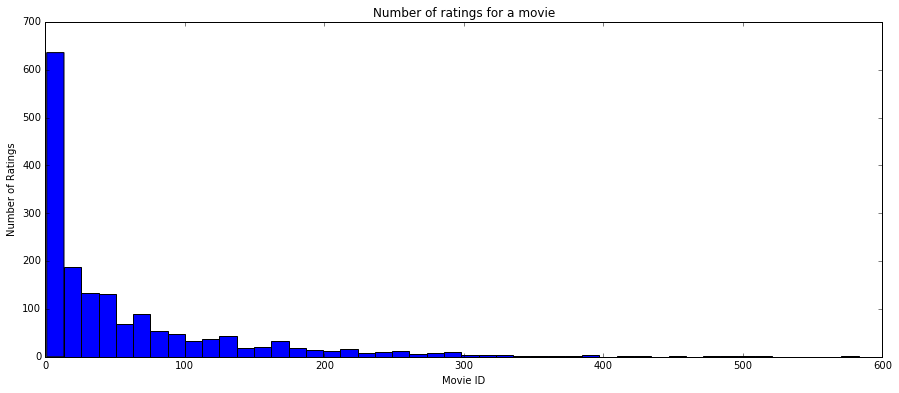

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,6))
plt.hist(rating_per_movie_count, bins='auto')  
plt.title('Number of ratings for a movie')
plt.xlabel('Movie ID')
plt.ylabel('Number of Ratings')
plt.show()

### #user_ratings = number of ratings for a user

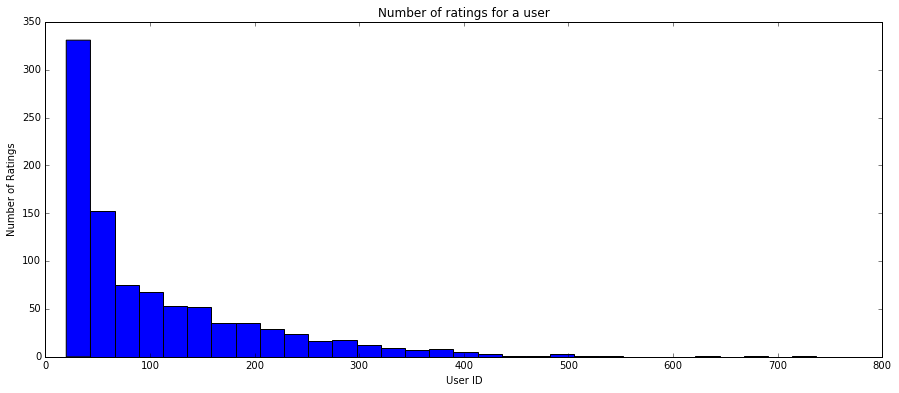

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,6))
plt.hist(rating_per_user_count, bins='auto')  
plt.title('Number of ratings for a user')
plt.xlabel('User ID')
plt.ylabel('Number of Ratings')
plt.show()

## Baseline Prediction

In [17]:
user_count = train_a['user id'].max()
item_count = train_a['item id'].max()

users = train_a['user id'].subtract(1)
items = train_a['item id'].subtract(1)
rating = train_a['rating']

A = csr_matrix((rating,(users,items)),dtype = np.float)

user_count_t = test_a['user id'].max()
item_count_t = test_a['item id'].max()

users_t = test_a['user id'].subtract(1)
items_t = test_a['item id'].subtract(1)
rating_t = test_a['rating']

R = csr_matrix((rating_t,(users_t,items_t)),dtype = np.float)

In [18]:
def compute_mu(A):
    
    user_count,item_count = A.shape  
    full_sum = A.sum(axis=None)  
    nnz = A.getnnz(axis=None)   
    mu = full_sum / nnz
    mu_full = np.tile(mu,(user_count,item_count))
    
    return mu,mu_full

In [19]:
def compute_bi(A):
    
    lambda2 = 25
    user_count,item_count = A.shape

    col_sum = A.sum(axis = 0)
    c = np.array(col_sum)
    nnz = A.getnnz(axis = 0)
    
    bi = (col_sum[0] - nnz*mu) / (lambda2+nnz)
    
    bi_full = np.tile(bi,(user_count,1))
    
    return bi,bi_full

In [20]:
def compute_bu(A):
    
    lambda3 = 10
    user_count,item_count = A.shape

    row_sum = A.sum(axis = 1)
    nnz = A.getnnz(axis = 1)

    bic = []

    for user in range(user_count) :

        _,item_ids = A.getrow(user).nonzero()
        bic.append(bi[0,[item_ids]].sum())

    bu = (row_sum.reshape(user_count,) - nnz*mu - np.asarray(bic)) / (lambda3+nnz)   
    bu_full = np.tile(bu.transpose(),(1,item_count))
    
    return bu,bu_full

## Test RMSE

In [21]:
def compute_rmse(A,R) :
    
    #mu,mu_full = compute_mu(A)
    #bi,bi_full = compute_bi(A)
    bu,bu_full = compute_bu(A)
    
    T = mu_full + bu_full + bi_full

    rows, cols = R.nonzero()
    rmse = 0
    count = 0

    for row,col in zip(rows,cols) :
        
#         t = mu + bu[row] + bi[0,col]
#         rmse += pow((R[row,col]-t),2)
        rmse += pow((R[row,col]-T[row,col]),2)
        count += 1

    rmse = pow(rmse/count,0.5)
    
    return rmse, T
    

In [24]:
mu,mu_full = compute_mu(A)
bi,bi_full = compute_bi(A)
bu,bu_full = compute_bu(A)
rmse,T = compute_rmse(A,R)
T = csr_matrix(T)
print ("Rmse for test data : ",rmse)

Rmse for test data :  0.966481783888


### RMSE for user for 5 groups

In [98]:
col_sum = A.sum(axis=1)
nnz = A.getnnz(axis=1)
user_count,item_count = A.shape

user_avg = col_sum.reshape(user_count,) / nnz

min_rating = user_avg.min()
max_rating = user_avg.max()

segment = (max_rating - min_rating)/5

user_avg = np.asarray(user_avg)
user_avg = user_avg.reshape(user_count)

In [99]:
def rmse_user(user_ids,R,T):
    rmse = 0
    count = 0
    for u in user_ids[0]:
        _,items = R.getrow(u).nonzero()   
        for i in items:
            rmse += pow((R[u,i] - T[u,i]),2) 
            count += 1
            
    rmse = pow(rmse/count,0.5)
    return rmse
    

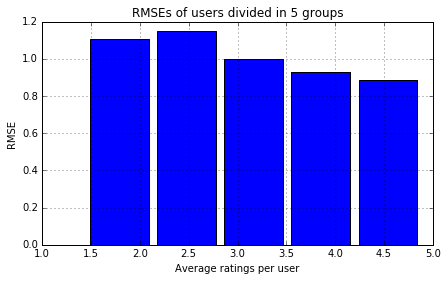

In [101]:
grp5 = []
x = []
end = min_rating
for i in range(5):
    prev = end
    x.append(prev)
    end = prev + segment
    user_ids = np.where((user_avg>=prev) & (user_avg<end))
    grp5.append(rmse_user(user_ids,R,T))

plt.figure(figsize=(7,4))
plt.bar(x, grp5, width=0.6, align='edge')
plt.ylabel('RMSE')
plt.xlabel('Average ratings per user')
plt.title('RMSEs of users divided in 5 groups')
plt.grid(True)
plt.show()


## Item Similarity

In [48]:
#User Averages
from numpy import linalg as LA
import time 
row_sum = A.sum(axis = 1)
nnz = A.getnnz(axis = 1)
user_count,item_count = A.shape  
user_avg = np.array(row_sum.reshape(user_count)/nnz).transpose()

#### Functions to compute user average and item average 

In [ ]:
def userAvg(Af, users, mu):
    avgR = [0.0 for x in range(users)]
    for i in range(users):
        ratings = Af[i, :]
        denom = 0.0
        num = 0.0
        for j in range(len(ratings)):
            eachRating = Af[i, j]
            if eachRating > 0:
                num += eachRating
                denom += 1
        if denom == 0:
            avgR[i] = mu
        else:
            avgR[i] = num / denom
    maxR = max(avgR)
    minR = min(avgR)
    interval = (maxR - minR) / 5.0
    bins = [minR + i * interval for i in range(5)]
    bins_of_user = np.digitize(avgR, bins) 
    return avgR

def itemAvg(Af, items, mu):
    avgR = [0.0 for x in range(items)]
    for i in range(items):
        ratings = Af[:, i]
        denom = 0.0
        num = 0.0
        for j in range(len(ratings)):
            eachRating = Af[j, i]
            if eachRating > 0:
                num += eachRating
                denom += 1
        if denom == 0:
            avgR[i] = mu
        else:
            avgR[i] = num / denom
    return avgR

#### Function to compute the item similarity matrix

In [138]:
start = time.time()
item_similarity = np.zeros(shape=(item_count, item_count))
item_similarity[:,:] = -9999.0
Adense = A.todense()

for i1 in range(item_count):   
    #if((i1+1)%10 == 0): print (i1+1)
    u1 = np.where(Adense[:,i1]>0)[0]
    for i2 in range (i1+1,item_count): 
        u2 = np.where(Adense[:,i2]>0)[0]
        u_com = np.intersect1d(u1, u2)
        v1 = Adense[u_com,i1] - user_avg[u_com]
        v2 = Adense[u_com,i2] - user_avg[u_com] 
        if(LA.norm(v1)*LA.norm(v2) == 0): continue
        item_similarity[i1,i2] = float((np.dot(np.transpose(v1),v2)) / (LA.norm(v1)*LA.norm(v2)))
        item_similarity[i2,i1] = item_similarity[i1,i2]

end = time.time()

Rf = np.array(R.todense())
#Af = np.array(A.todense())
#avguser = userAvg(Af, user_count, mu)
#avgitem = itemAvg(Af,item_count, mu)

#### Function to compute RMSE

In [148]:
def compute_k_rmse(k) :
    rows, cols = np.where(Rf>0)
    rmse = 0
    count = 0
    for row,col in zip(rows,cols) :      
        t = knn(col,row,k)
        rmse += pow((Rf[row,col]-t),2)
        count += 1

    rmse = pow(rmse/count,0.5)
    return rmse

#### Function to compute the predicted user rating

In [140]:
def knn(itemId, userId, k):
        similarItems = item_similarity[itemId].copy()      
        userRating = Af[userId, :]
        for i in range(len(similarItems)):
            if userRating[i] < 1:
                similarItems[i] = -9999999      
        topK = np.argpartition(similarItems, len(similarItems)-k)[-k:]
        num = 0.0
        denom = 0.0
        for eachItem in topK:
            ratedVal = userRating[eachItem]
            if ratedVal < 1:
                ratedVal = avgitem[itemId]
            if ratedVal > 0:
                num += (ratedVal * similarItems[eachItem])
                denom += (abs(similarItems[eachItem]))     
        if denom == 0: return mu
        rating = num / denom
        if rating < 1: rating = 1
        elif rating > 5: rating = 5 
        return rating 

### RMSE values for k = 1,2,3,510

In [144]:
rmse_k = []
x = [1,2,3,5,10]
for e in x:
    rmse_k.append(compute_k_rmse(e))
              
print (rmse_k)

[1.3730090183903105, 1.1883729425165788, 1.1162625755778584, 1.0656028132687985, 1.1867109240208888]


We see that rmse is best for k = 5

### RMSE for k = 1,2,3,5,10

In [146]:
def rmse_user_k(user_ids,k):
    rmse = 0
    count = 0
    for u in user_ids[0]:
        items = np.where(Rf[u,:]>0)
        for i in items[0]:
            #print ("hi",i,u)
            t = knn(i,u,k)
            rmse += pow((Rf[u,i] - t),2) 
            count += 1
            
    rmse = pow(rmse/count,0.5)
    return rmse

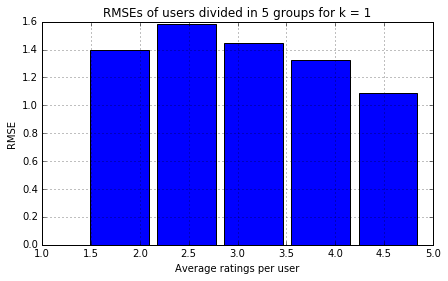

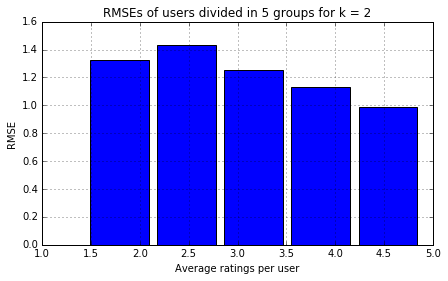

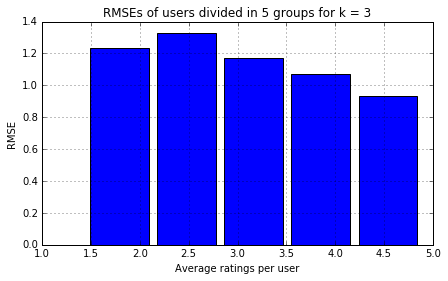

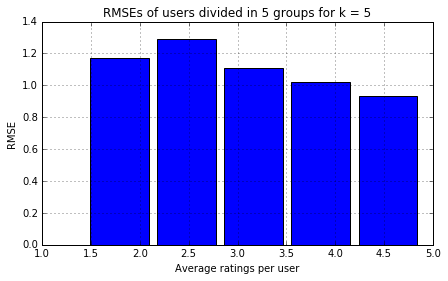

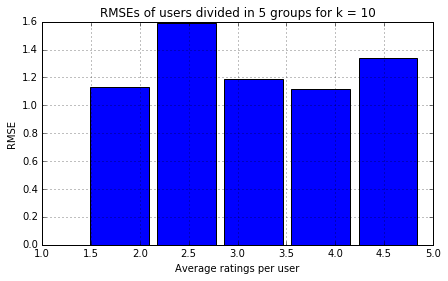

In [149]:
grp5_1 = []
grp5_2 = []
grp5_3 = []
grp5_5 = []
grp5_10 = []
x = []
end = min_rating
for i in range(5):
    prev = end
    x.append(prev)
    end = prev + segment
    user_ids = np.where((user_avg>=prev) & (user_avg<end))
    grp5_1.append(rmse_user_k(user_ids,1))
    grp5_2.append(rmse_user_k(user_ids,2))
    grp5_3.append(rmse_user_k(user_ids,3))
    grp5_5.append(rmse_user_k(user_ids,5))
    grp5_10.append(rmse_user_k(user_ids,10))

plt.figure(figsize=(7,4))
plt.bar(x, grp5_1, width=0.6, align='edge')
plt.ylabel('RMSE')
plt.xlabel('Average ratings per user')
plt.title('RMSEs of users divided in 5 groups for k = 1')
plt.grid(True)
plt.show()

plt.figure(figsize=(7,4))
plt.bar(x, grp5_2, width=0.6, align='edge')
plt.ylabel('RMSE')
plt.xlabel('Average ratings per user')
plt.title('RMSEs of users divided in 5 groups for k = 2')
plt.grid(True)
plt.show()

plt.figure(figsize=(7,4))
plt.bar(x, grp5_3, width=0.6, align='edge')
plt.ylabel('RMSE')
plt.xlabel('Average ratings per user')
plt.title('RMSEs of users divided in 5 groups for k = 3')
plt.grid(True)
plt.show()

plt.figure(figsize=(7,4))
plt.bar(x, grp5_5, width=0.6, align='edge')
plt.ylabel('RMSE')
plt.xlabel('Average ratings per user')
plt.title('RMSEs of users divided in 5 groups for k = 5')
plt.grid(True)
plt.show()

plt.figure(figsize=(7,4))
plt.bar(x, grp5_10, width=0.6, align='edge')
plt.ylabel('RMSE')
plt.xlabel('Average ratings per user')
plt.title('RMSEs of users divided in 5 groups for k = 10')
plt.grid(True)
plt.show()